# The Thinnest Slice of FDTD

How thin can a volume in FDTD be before artifacts start popping out?

To study this consider a monochromatic field corresponding to a wavelength of 532 nm. Have a plane wave incident from inside a medium similar to water (n=1.33) and transmitting into air (n=1.0003).

As a simulation region use a parallelepiped with square cross section 10 um on the side, and thickness H.

Set up a source below the interface at a distance $\lambda^* = \max(\lambda_1, \lambda_2)$.

Set up a monitor above the interface at a distance $\lambda$ collecting all the components of the electric field.

Leave a distance $\kappa$ between the top edge of the simulation region and the monitor, and the same distance between the bottom edge of the simulation box and the source.

As such the total thickness of the simulation region is $H =  2(\kappa + \lambda^*)$

For each $\kappa$ determine with the results of the monitor what fraction of the power $T(\kappa)$ from the source transmitted into the upper volume.

Vary $\kappa$ from 0 to $4\lambda^*$ and plot $T(\kappa)$. When performing each simulation make sure to save the time that each simulation took to run, and also plot these as a function of $\kappa$.


In [1]:
import numpy as np
import time
import os
%load_ext autoreload
%autoreload 2
import rspie as rs
from matplotlib import pyplot as plt

In [17]:
def bouncer(kappa):
	vartext = '''
	filename = fdtdslice.ind
	prefix = fdtdslice
	H = 2*lambda_star + kappa
	H1 = lambda_star
	H2 = lambda_star + kappa
	alpha = 0
	background_index = 1
	boundary_max = width/2
	boundary_max_y = width/2
	boundary_min = -width/2
	boundary_min_y = -width/2
	cad_aspectratio = 1
	delta = index-background_index
	dimension = 3
	domain_max = H2
	domain_min = -H1
	eim = 0
	fdtd_complex = 1
	fdtd_display_res_auto = DISPLAY_RES_AUTO
	fdtd_monitor_time = lambda/4
	fdtd_monitor_time_auto = MONITOR_TIME_AUTO
	fdtd_pml_cells_enable = 1
	fdtd_stop_auto = 1
	fdtd_stop_time = 25.696
	fdtd_stop_time_auto = 1
	fdtd_time_step = 0.0133
	fdtd_time_step_auto = 1
	fdtd_update_time = 9*lambda/4
	fdtd_update_time_auto = DISPLAY_TIME_AUTO
	free_space_wavelength = 0.532
	grid_resolution = 0.01
	grid_size = grid_resolution
	grid_size_y = grid_resolution
	height = width
	index = 1
	index_display_mode = DISPLAY_CONTOURMAPXZ
	k0 = (2*pi)/free_space_wavelength
	kappa = %f
	lambda = free_space_wavelength
	lambda_0 = free_space_wavelength
	lambda_1 = lambda_0/n1
	lambda_2 = lambda_0/n2
	lambda_star = max(lambda_1,lambda_2)
	launch_align_file = 1
	launch_height = inf
	launch_normalization = 2
	launch_tilt = 1
	launch_type = LAUNCH_PLANEWAVE
	launch_width = inf
	n1 = 2.41
	n2 = 1.0003
	sim_tool = ST_FULLWAVE
	step_size = grid_resolution
	structure = STRUCT_CHANNEL
	width = 3''' % kappa

	bottom_segment = '''
		extended = 1
		begin.x = 0
		begin.z = -lambda_star
		begin.height = width
		begin.delta = n1-background_index
		end.x = 0
		end.y = 0
		end.z = 0
		end.height = width
		end.delta = n1-background_index
		'''
	top_segment = '''
		color = 11
		extended = 1
		begin.x = 0
		begin.y = 0
		begin.z = 0
		begin.delta = n2-background_index
		end.x = 0
		end.y = 0
		end.z = H2
		end.delta = n2-background_index
		'''

	launch_text = '''
		launch_pathway = 1
		launch_type = LAUNCH_PLANEWAVE
		launch_tilt = 1
		launch_normalization = 2
		launch_align_file = 1
		launch_width = inf
		launch_height = inf
	'''

	monitor_segment = '''
		profile_type = PROF_INACTIVE
		color = 2
		type = TIMEMON_EXTENDED
		timeaverage = 2
		complexmonitor = 1
		monitoroutputmask = 0
		monitoroutputformat = OUTPUT_REAL_IMAG
		fieldoutputmask = 14
		fieldoutputformat = OUTPUT_REAL_IMAG
		frequencyanalysis = TIMEMON_FA_DFT
		begin.x = 0
		begin.z = lambda_star
		begin.height = width
		'''

	vars = rs.selfref_def_parser(vartext)

	config = {}
	config['vars'] = vars
	config['monitors'] = [rs.selfref_def_parser(monitor_segment, config['vars'])]
	config['segments'] = [bottom_segment, top_segment]
	for idx, segment in enumerate(config['segments']):
		config['segments'][idx] = rs.selfref_def_parser(segment,  config['vars'])
	config['launch_fields'] = [rs.selfref_def_parser(launch_text, config['vars'])]
	circuit = rs.PhotoCircuit(config)
	start_time = time.time()
	circuit.run()
	end_time = time.time()
	out_field = {}
	for component in 'xyz':
		fname = os.path.join(circuit.sim_dir, 'fdtdslice_m3_f2_e%s.dat' % component)
		field_format, x_coords, y_coords, num_array = rs.load_2d_dat(fname)
		out_field[component] = num_array
	return config, start_time, end_time, x_coords, y_coords, out_field


In [18]:
kappas =  np.linspace(0.01, 0.1, 10)

In [19]:
kappas

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [20]:
runs = {}
for kappa in kappas:
    print(kappa)
    runs[kappa] = bouncer(kappa)

0.01
0.020000000000000004
0.030000000000000006
0.04000000000000001
0.05000000000000001
0.06000000000000001
0.07
0.08
0.09000000000000001
0.1


In [ ]:
import pickle

In [ ]:
pickle.dump(runs, open('slice-runs-finer.pickle', 'wb'))

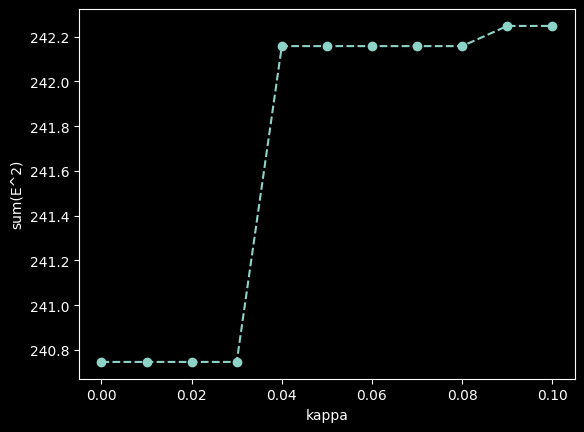

In [ ]:
squaredE = []
for kappa in runs:
    squaredE.append(np.sum(np.abs(runs[kappa][-1]['x'])**2))
plt.figure()
plt.plot(kappas, squaredE,'o--')
plt.xlabel('kappa')
plt.ylabel('sum(E^2)')
plt.show()

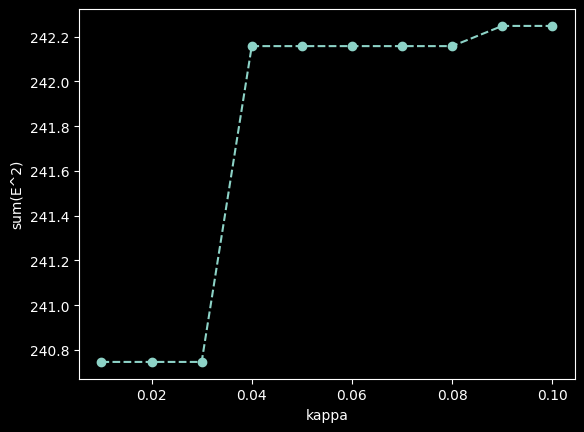

In [ ]:
plt.figure()
plt.plot(kappas[1::], squaredE[1::],'o--')
plt.xlabel('kappa')
plt.ylabel('sum(E^2)')
plt.show()

In [ ]:
rs.send_message('done')

'{"status":1,"request":"25902169-761b-4fc2-9f8c-6abbd138df15"}'